In [56]:
import ngmix
import galsim
import fitsio
import numpy as np

import proplot as pplt

import matplotlib.pyplot as plt

In [3]:
d = fitsio.read("/Users/beckermr/Downloads/input_cosmos_v4.fits")

In [5]:
d.dtype.names

('des_id',
 'bdf_hlr',
 'bdf_fracdev',
 'mask_flags',
 'bdf_g1',
 'bdf_g2',
 'flux_u',
 'flux_g',
 'flux_r',
 'flux_i',
 'flux_z',
 'flux_Y',
 'flux_J',
 'flux_H',
 'flux_Ks',
 'mag_u',
 'mag_g',
 'mag_r',
 'mag_i',
 'mag_z',
 'mag_Y',
 'mag_J',
 'mag_H',
 'mag_Ks',
 'flux_u_dered',
 'flux_g_dered',
 'flux_r_dered',
 'flux_i_dered',
 'flux_z_dered',
 'flux_Y_dered',
 'flux_J_dered',
 'flux_H_dered',
 'flux_Ks_dered',
 'mag_u_dered',
 'mag_g_dered',
 'mag_r_dered',
 'mag_i_dered',
 'mag_z_dered',
 'mag_Y_dered',
 'mag_J_dered',
 'mag_H_dered',
 'mag_Ks_dered',
 'laigle_number',
 'photoz',
 'zp_2',
 'zpdf_l68',
 'zpdf_h68',
 'class',
 'isgal')

In [7]:
# do some cuts from https://github.com/des-science/y3-wl_image_sims/blob/master/end_to_end/config_files/e2e-008.yaml
# mag_i: [15., 25.]  #use only 15<mag_i<25. for now.
# isgal: [1,] #select galaxies only since we're simulating stars separately.
# mask_flags: [0,] #apply mask flags
# bdf_hlr: [0.,5.]

msk = (
    (d["mag_i"] >- 15)
    & (d["mag_i"] <= 25)
    & (d["isgal"] == 1)
    & (d["mask_flags"] == 0)
    & (d["bdf_hlr"] >= 0)
    & (d["bdf_hlr"] <= 5)
)

In [8]:
d = d[msk]

In [97]:
from ngmix.prepsfmom import PGaussMom

PMOM = PGaussMom(2.0)

def get_bdf_gap(hlr, fracdev, flux, g1, g2, pixel_scale=0.05):
    """

    items:
        - type: Exponential
          half_light_radius: { type: catalog_sampler_value, col: bdf_hlr }
          ellip:
              type: GBeta
              g: { type: Eval, str: "np.sqrt(g1**2 + g2**2)", fg1: { type: catalog_sampler_value, col: bdf_g1 }, fg2: { type: catalog_sampler_value, col: bdf_g2 } }
              beta: { type: Random }
          flux: { type: Eval, str: "1-fracdev", ffracdev: { type: catalog_sampler_value, col: bdf_fracdev } }

        - type: DeVaucouleurs
          half_light_radius: '@gal.items.0.half_light_radius'
          ellip: "@gal.items.0.ellip"
          flux: "$1-@gal.items.0.flux"


    """
    _exp = (1.0 - fracdev) * galsim.Exponential(half_light_radius=hlr).shear(g1=g1, g2=g2)
    _dev = fracdev * galsim.DeVaucouleurs(half_light_radius=hlr).shear(g1=g1, g2=g2)
    gal = flux * (_exp + _dev)
    gal_img = gal.drawImage(scale=pixel_scale, method="sb").array

    fgauss = galsim.Gaussian(
        fwhm=2.0
    )
    filter_img = galsim.Gaussian(
        fwhm=2.0
    ).drawImage(
        nx=gal_img.shape[1], 
        ny=gal_img.shape[0], 
        method="sb",
        scale=pixel_scale
    ).array

    gap_flux = np.sum(gal_img * filter_img) / fgauss.max_sb * pixel_scale**2

    if False:
        # this bit of code double check the ngmix pgauss flux is the same 
        # as the galsim flux above
        # worked fine!
        cen = (gal_img.shape[0] - 1)/2.0
        obs = ngmix.Observation(
            image=gal_img,
            weight=np.ones_like(gal_img),
            jacobian=ngmix.DiagonalJacobian(
                scale=pixel_scale,
                row=cen,
                col=cen,
            )
        )
        res = PMOM.go(obs, no_psf=True)
        print(res["flux"] * pixel_scale**2, gap_flux)

    return gap_flux

In [98]:
ind = 231

gap_flux = get_bdf_gap(
    d["bdf_hlr"][ind], 
    d["bdf_fracdev"][ind],
    d["flux_i"][ind],
    d["bdf_g1"][ind],
    d["bdf_g2"][ind],
    pixel_scale=0.05,
)

In [52]:
from esutil.pbar import PBar

gap_mag = []

for ind in PBar(range(len(d))):

    gap_flux = get_bdf_gap(
        d["bdf_hlr"][ind], 
        d["bdf_fracdev"][ind],
        d["flux_i"][ind],
        d["bdf_g1"][ind],
        d["bdf_g2"][ind],
        pixel_scale=0.05,
    )
    gap_mag.append(
        30.0 -2.5*np.log10(gap_flux)
    )

|--------------------| 2444/117514   2% [elapsed: 00:13 left: 10:38]/var/folders/41/j8jxg9p94cd_04wlhd_zn0lr0000gn/T/ipykernel_58268/1450659654.py:16: RuntimeWarning: invalid value encountered in log10
  30.0 -2.5*np.log10(gap_flux)
|###########---------| 70096/117514  59% [elapsed: 06:28 left: 04:22]/var/folders/41/j8jxg9p94cd_04wlhd_zn0lr0000gn/T/ipykernel_58268/1450659654.py:16: RuntimeWarning: divide by zero encountered in log10
  30.0 -2.5*np.log10(gap_flux)
|####################| 117514/117514 100% [elapsed: 10:38 left: 00:00]


In [81]:
gap_mag = np.asarray(gap_mag)

bin_edges = np.linspace(17, 25, 25)
bmag = []
dmag = []
for i in range(len(bin_edges)-1):
    msk = (
        (d["mag_i"] >= bin_edges[i])
        & (d["mag_i"] <= bin_edges[i+1])
    )
    bmag.append(np.nanmedian(d["mag_i"][msk]))
    dmag.append(np.nanmedian(gap_mag[msk]) - bmag[-1])

/Users/beckermr/mambaforge/envs/des-y6/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Text(0, 0.5, 'pgauss - cosmos')

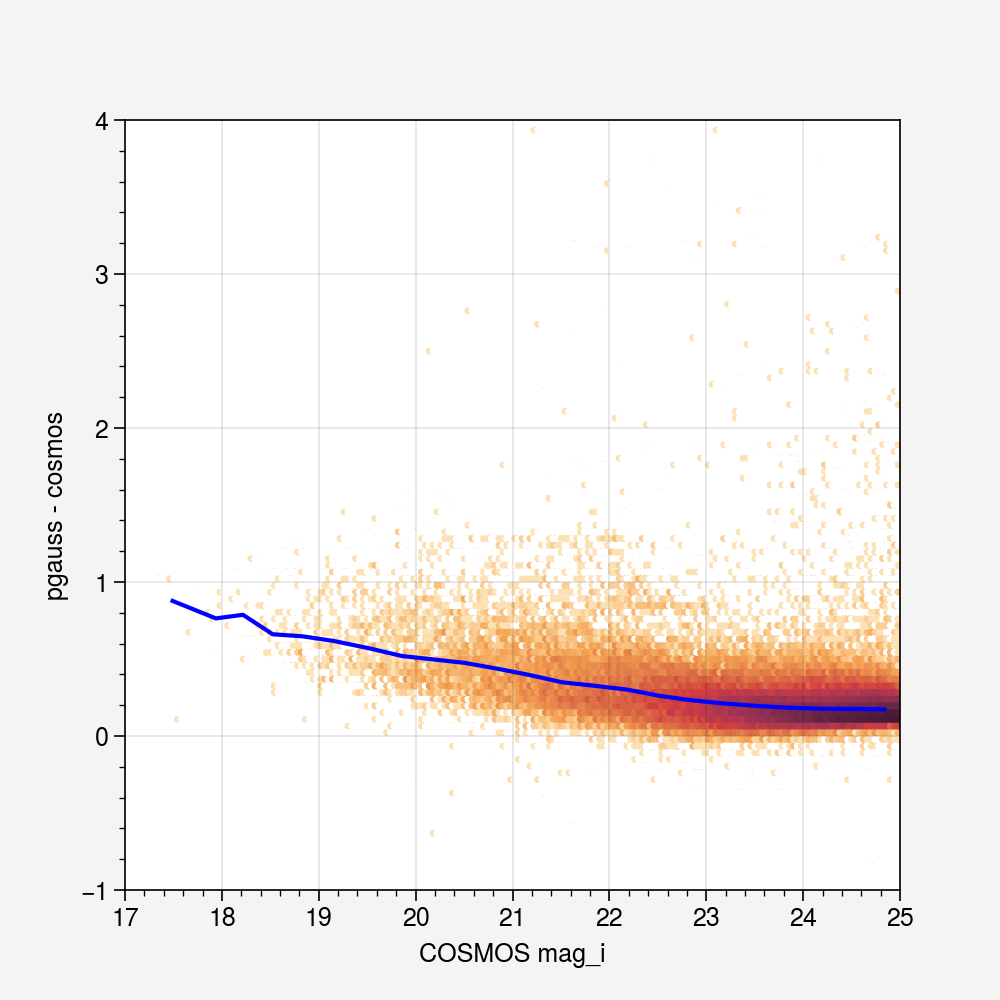

In [82]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.hexbin(
    d["mag_i"], 
    gap_mag-d["mag_i"], 
    gridsize=200,
    bins="log",
    extent=[17, 25, -1, 4],
)
axs.plot(bmag, dmag, "-", color="blue")
axs.set_xlim(17, 25)
axs.set_ylim(-1, 4)
axs.set_xlabel("COSMOS mag_i")
axs.set_ylabel("pgauss - cosmos")

In [103]:
print("The new cut is:", np.round(
    np.interp(24.5, bmag, dmag) + 24.5,
    2,
))

The new cut is: 24.68
